# Analisis de la contaminación del aire en PM 2.5

El índice de partículas finas (PM 2.5) se refiere a partículas en suspensión con un diámetro aerodinámico menor o igual a 2.5 micrómetros (micras). Estas partículas son extremadamente pequeñas, aproximadamente 30 veces más pequeñas que el diámetro de un cabello humano, y son una de las principales medidas para evaluar la contaminación del aire.

Fuentes de PM 2.5:
- Naturales: Incendios forestales, tormentas de polvo, erupciones volcánicas.
- Humanas: Combustión de combustibles fósiles (vehículos, centrales eléctricas), quemas agrícolas, industria, humo de cigarrillo, entre otras.

Indice de calidad de aire
+ Bueno: 0 - 50, La contaminación del aire representa poco o ningún riesgo.
+ Moderado: 51 - 100, Puede haber algún riesgo para personas que son inusualmente sensibles a la contaminación del aire.
+ No saludable para grupos sensibles: 101 - 150, Personas con problemas cardíacos o pulmonares pueden experimentar efectos en su salud.
+ No saludable: 151 - 200, Miembros del público en general pueden experimentar efectos en su salud.
+ Muy no saludable: 201 - 300, El riesgo de efectos en la salud aumenta para todos.
+ Peligroso: 300+, Advertencia de salud por condiciones de emergencia.


Las fuentes son:

- Environment & Health Data Portal = 
    1. https://a816-dohbesp.nyc.gov/IndicatorPublic/data-explorer/air-quality/?id=2023#display=summary
        + Acerca de los datos: Los datos de este archivo son mediciones promedio por hora de PM2.5 de la red de sensores DustTrak de TSI de la Encuesta del Aire Comunitario de la Ciudad de Nueva York. Las diferentes tecnologías de sensores darán como resultado lecturas diferentes
        + Mediciones: El valor mostrado es PM2.5 en microgramos por metro cúbico de aire (µg/m3). ObservationTimeUTCLa fecha y hora que se muestra es el comienzo de las mediciones promedio de PM2.5 para la hora (por ejemplo, 1/2/2020 1:00:00 AM (UTC) refleja los datos recopilados entre el 1/2/2020 1:00:00 AM (UTC) y el 1/2/2020 1:59:00 AM (UTC)).
    
    2. https://azdohv2staticweb.blob.core.windows.net/$web/hist/csv/2025/1/hourlyMonitoring.csv (tiempo real)
- Open data = https://data.cityofnewyork.us/Environment/Air-Quality/c3uy-2p5r/about_data?utm_source=chatgpt.com

A continuación enumeraremos la aplicación de Machine learning para estos datos. 

1. Analisis histórico de los datos sensores 22-24
    + Primer modelo series de tiempo: Uso del algoritmo Arima 
    + Segundo modelo series de tiempo: Uso del algoritmo Prophet
2. Clustering Basado en Sitios desde location.csv y sensores 22-24.
    + Creación nuevo data set: MergeValueLocation.scv
    + Api de agrupación por Indice de contaminación
        - Modelos utilizados: Kmeans, regresión lineal.
    + Función que devuelve, con los datos de los sensores un mapa con la zona seleccionada en color (según el indice de metricas) y sus datos de contaminación por número de mes, día y hora. 
3. Modelo de clustering en data set Air quality (m): se desarrollará un modelo de agrupamiento que clasifique las Boroughs en función de sus características clave: Indicator ID, Name, Measure, Measure Info, Start_Date, y Data Value.
    - Obtención del numero optimo de clusters con elbow 
    - Aplicación del algorimo kmeans para agrupar
    - Cración de Boroughs_Clusters.csv el cual contiene la data para trabajar 
    - Se obtiene graficos aleatorios de zonas con variables 
    - Análisis de correlación con regresión lineal: Gráfico de regresión lineal que muestra la correlación entre tránsito y pm 2.5
    - Grafico de las 10 zonas que se acercan a la recta de regresión. 

# Analisis histórico de los datos Sensores 22-24.

En primera instancia revisaremos los data set de Sensores 22-24 que hemos obtenido (se recolectó los data set de cada mes en los años 2022 a 2024 y se unió a un solo data set: sensores 22-24) y que irdemos trabajando para revisar las columnas de interes y visualizar el analisis a realizar. 

En una primera instancia vamos a unir archivos csv en uno solo para compatar nuestro analisis. 

# Aplicación de ML: Series de tiempo(Arima)

Flujo de trabajo para la predicción de series de tiempo:

1. Preprocesamiento de datos:
    - Convertir las fechas a un formato adecuado (datetime).
    - Configurar la columna ObservationTimeUTC como índice.
    - Manejar valores nulos en la columna Value.
2. Exploración de datos:
    - Visualizar la serie de tiempo para identificar tendencias y estacionalidades.
    - Dividir los datos en conjuntos de entrenamiento y prueba.
3. Entrenamiento del modelo:
    - Empezaremos con un modelo simple como ARIMA/SARIMA.
    - Ajustaremos parámetros usando validación cruzada.
4. Evaluación del modelo:
    - Calcular métricas como RMSE, MAE, y MAPE.
    - Comparar predicciones con valores reales.
5. Predicción futura:
    - Generar predicciones para las próximas horas o días.


In [109]:
import pandas as pd

# Cargar el dataset
file_path = 'sensores 22-24.csv'  # Cambia esto por la ruta real
data = pd.read_csv(file_path)

# Convertir la columna de tiempo a datetime y establecer como índice
data['ObservationTimeUTC'] = pd.to_datetime(data['ObservationTimeUTC'], errors='coerce')
data = data.set_index('ObservationTimeUTC')

# Filtrar solo la columna "Value" y eliminar valores nulos
data = data[['Value']].dropna()

# Eliminar duplicados en el índice
data = data[~data.index.duplicated(keep='first')]

# Verificar los datos preprocesados
print(data.info())
print(data.head())


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24654 entries, 2022-01-01 00:00:00 to 2024-12-31 23:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Value   24654 non-null  float64
dtypes: float64(1)
memory usage: 385.2 KB
None
                     Value
ObservationTimeUTC        
2022-01-01 00:00:00  18.96
2022-01-01 01:00:00  22.41
2022-01-01 02:00:00  22.15
2022-01-01 03:00:00  27.13
2022-01-01 04:00:00  20.72


In [110]:
# Dividir el dataset en entrenamiento (80%) y prueba (20%)
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

# Restablecer la frecuencia temporal para entrenamiento y prueba
train = train.asfreq('H')
test = test.asfreq('H')

print(f"Tamaño del conjunto de entrenamiento: {len(train)}")
print(f"Tamaño del conjunto de prueba: {len(test)}")


Tamaño del conjunto de entrenamiento: 21373
Tamaño del conjunto de prueba: 4931


C:\Users\jerom\AppData\Local\Temp\ipykernel_29832\2700166924.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  train = train.asfreq('H')
C:\Users\jerom\AppData\Local\Temp\ipykernel_29832\2700166924.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  test = test.asfreq('H')


In [111]:
%pip install pmdarima


Note: you may need to restart the kernel to use updated packages.


In [112]:
# Eliminar valores nulos para que funcione el algoritmo arima
data_cleaned = data.dropna()

# Verificar si quedan valores nulos
print(data_cleaned.isna().sum())


Value    0
dtype: int64


In [114]:
from statsmodels.tsa.arima.model import ARIMA

# Ajuste manual de un modelo ARIMA con parámetros (p, d, q)
model = ARIMA(train, order=(2, 1, 2))
model_fit = model.fit()

# Resumen del modelo ajustado
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                21373
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -96952.442
Date:                Wed, 08 Jan 2025   AIC                         193914.885
Time:                        01:03:02   BIC                         193954.734
Sample:                    01-01-2022   HQIC                        193927.881
                         - 06-09-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0362      0.012     -3.032      0.002      -0.060      -0.013
ar.L2          0.0549      0.006      8.817      0.000       0.043       0.067
ma.L1         -0.4839      0.012    -40.802      0.0

RMSE: 5.86


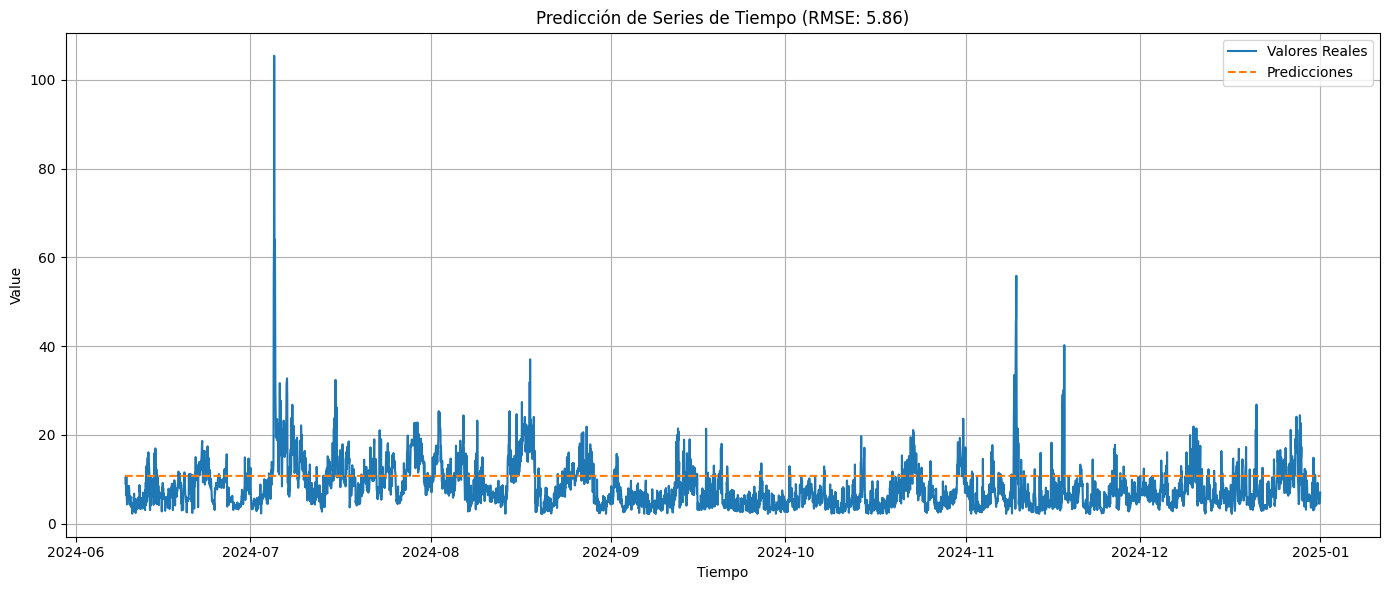

In [115]:
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Generar predicciones para el conjunto de prueba
predictions = model_fit.forecast(steps=len(test))
predictions = pd.Series(predictions, index=test.index)

# Eliminar posibles NaN y alinear datos
aligned_test = test.dropna(subset=['Value'])
aligned_predictions = predictions.dropna()

# Calcular métricas de desempeño
mse = mean_squared_error(aligned_test['Value'], aligned_predictions)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse:.2f}")

# Graficar valores reales vs predicciones
plt.figure(figsize=(14, 6))
plt.plot(aligned_test['Value'], label="Valores Reales")
plt.plot(aligned_predictions, label="Predicciones", linestyle='--')
plt.title(f"Predicción de Series de Tiempo (RMSE: {rmse:.2f})")
plt.xlabel("Tiempo")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\jerom\AppData\Local\Temp\ipykernel_29832\2148127154.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_index = pd.date_range(start=last_date, periods=future_steps + 1, freq='H')[1:]


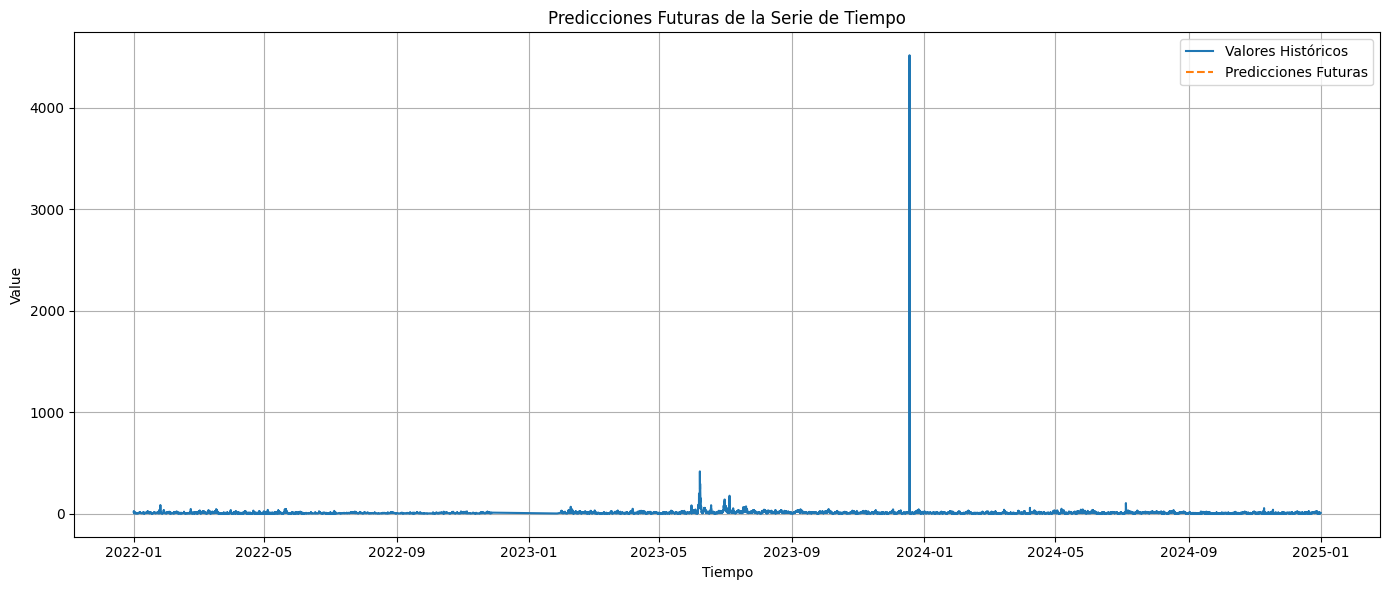

In [116]:
# Generar predicciones para 48 horas futuras
future_steps = 500
future_predictions = model_fit.forecast(steps=future_steps)

# Crear un índice de tiempo para las predicciones futuras
last_date = data.index[-1]
future_index = pd.date_range(start=last_date, periods=future_steps + 1, freq='H')[1:]

# Combinar predicciones con el índice
future_predictions = pd.Series(future_predictions, index=future_index)

# Graficar predicciones futuras
plt.figure(figsize=(14, 6))
plt.plot(data['Value'], label="Valores Históricos")
plt.plot(future_predictions, label="Predicciones Futuras", linestyle='--')
plt.title("Predicciones Futuras de la Serie de Tiempo")
plt.xlabel("Tiempo")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Aplicación de algoritmo Prophet
1. Predicción de patrones temporales:
- Usa Prophet para analizar y predecir valores futuros de Value, modelando patrones diarios y cualquier tendencia a largo plazo.
2. Estacionalidad diaria:   
- Prophet permite detectar y analizar ciclos diarios (hora a hora) para identificar cuándo ocurren los valores más altos o bajos.
Esto es útil para confirmar patrones como "los picos ocurren en la mañana y los valores más bajos de madrugada". 
3. Componentes del modelo:
- Prophet descompone los datos en tendencia, estacionalidad diaria y ruido, lo que te da una visión clara de qué impulsa las variaciones en Value.

# Detención de anomalías

# Flujo de trabajo recomendado con Prophet
1. Preprocesar los datos
Prophet requiere que el dataset tenga dos columnas: ds (fecha y hora) y y (el valor de interés).

In [118]:
from prophet import Prophet

# Crear el DataFrame requerido por Prophet
prophet_data = data.reset_index()[['ObservationTimeUTC', 'Value']]
prophet_data.rename(columns={'ObservationTimeUTC': 'ds', 'Value': 'y'}, inplace=True)
prophet_data.dropna(inplace=True)

# Verificar estructura
print(prophet_data.head())


                   ds      y
0 2022-01-01 00:00:00  18.96
1 2022-01-01 01:00:00  22.41
2 2022-01-01 02:00:00  22.15
3 2022-01-01 03:00:00  27.13
4 2022-01-01 04:00:00  20.72


2. Entrenar el modelo
Usa Prophet para ajustar el modelo con los datos disponibles.

In [119]:
# Crear y ajustar el modelo Prophet
model = Prophet(daily_seasonality=True)  # Incluye estacionalidad diaria
model.fit(prophet_data)


01:03:45 - cmdstanpy - INFO - Chain [1] start processing
01:03:51 - cmdstanpy - INFO - Chain [1] done processing


3. Predicción
Genera predicciones para un rango de tiempo futuro o incluso para los mismos datos históricos.

In [120]:
# Crear un rango futuro de fechas (730 horas a partir del último registro: un mes)
future = model.make_future_dataframe(periods= 730, freq='H')

# Generar predicciones
forecast = model.predict(future)

# Ver las columnas clave del forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())


c:\Users\jerom\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


                       ds      yhat  yhat_lower  yhat_upper
25379 2025-01-31 05:00:00 -4.348766  -46.689951   37.448812
25380 2025-01-31 06:00:00 -3.811827  -46.456758   39.905579
25381 2025-01-31 07:00:00 -2.856245  -45.794934   40.796084
25382 2025-01-31 08:00:00 -2.168723  -42.278878   38.877279
25383 2025-01-31 09:00:00 -2.221081  -43.887962   39.498381


4. Visualización de los resultados
Prophet tiene herramientas incorporadas para visualizar resultados.

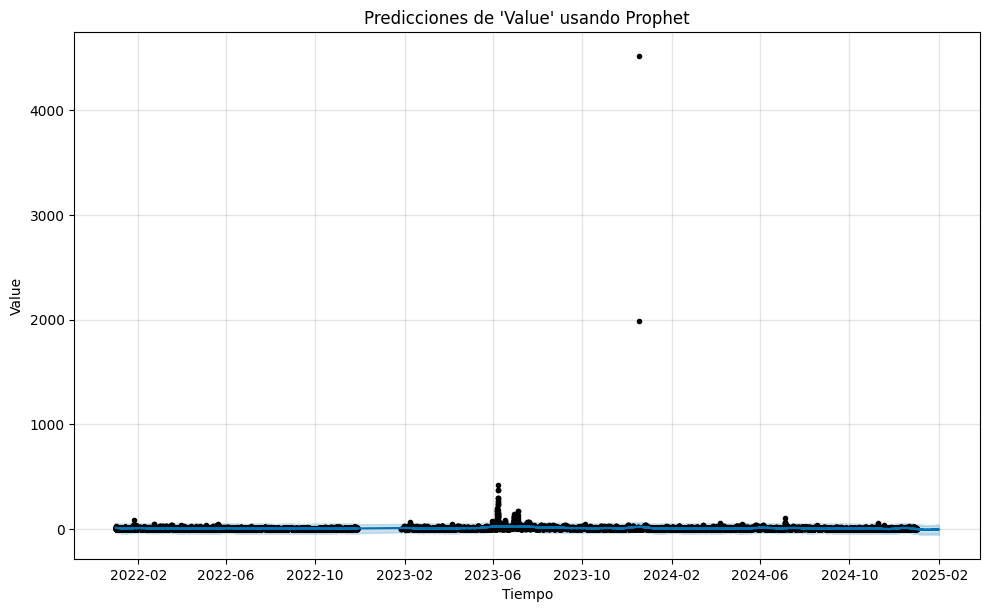

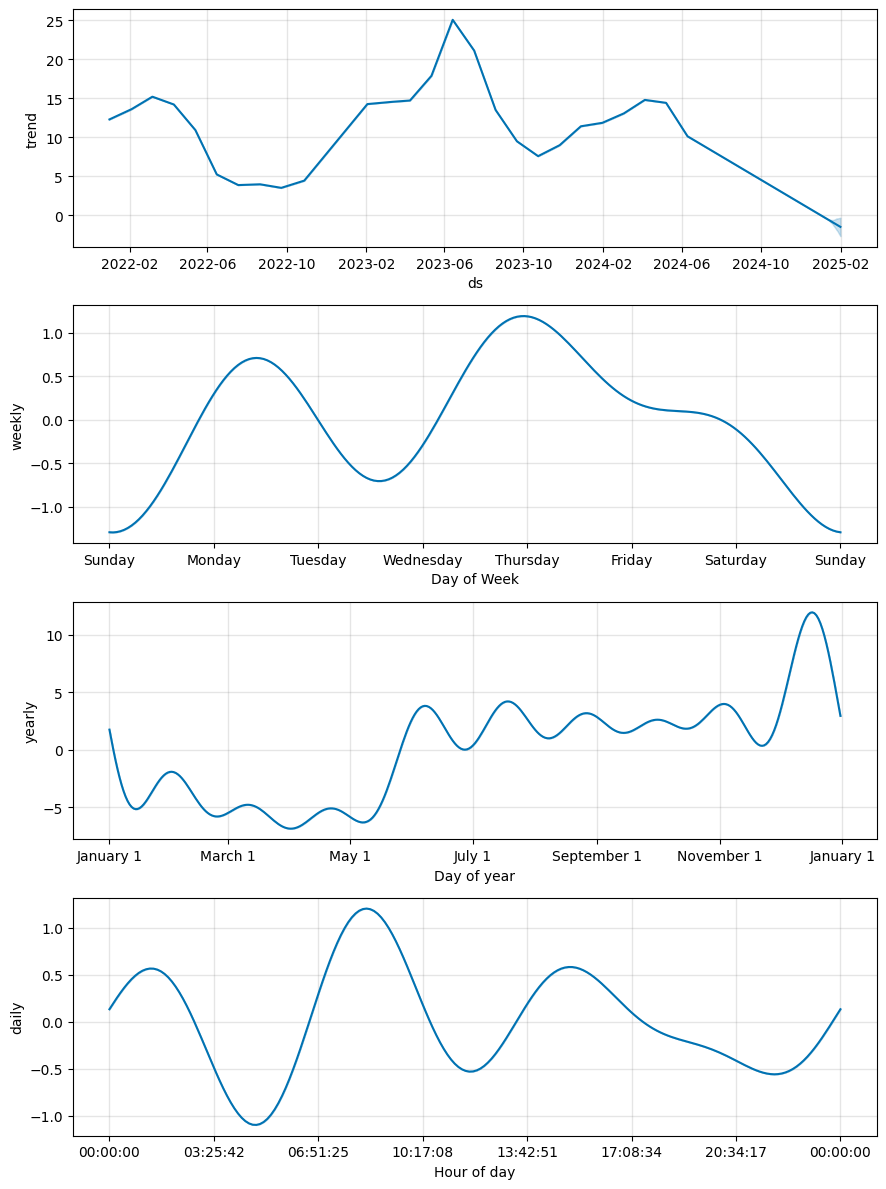

In [121]:
# Graficar las predicciones
model.plot(forecast)
plt.title("Predicciones de 'Value' usando Prophet")
plt.xlabel("Tiempo")
plt.ylabel("Value")
plt.show()

# Visualizar los componentes del modelo
model.plot_components(forecast)
plt.show()


Detención y eliminación anomalías
1. Definir anomalías:
    - Valores que se alejan significativamente del promedio o de la mediana de los datos.
    - Puede usarse un método estadístico como el rango intercuartílico (IQR) o desviación estándar.
2. Eliminar anomalías:
    - Una vez detectadas, puedes eliminarlas o imputarlas con valores representativos.
3. Ajustar Prophet sin anomalías:
    - Entrena el modelo nuevamente con los datos limpios.

In [122]:
# Calcular cuartiles e IQR
Q1 = data['Value'].quantile(0.25)
Q3 = data['Value'].quantile(0.75)
IQR = Q3 - Q1

# Identificar límites inferior y superior
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identificar anomalías
anomalies = data[(data['Value'] < lower_bound) | (data['Value'] > upper_bound)]
print(f"Anomalías detectadas: {len(anomalies)}")

# Eliminar anomalías
data_cleaned = data[(data['Value'] >= lower_bound) & (data['Value'] <= upper_bound)]


Anomalías detectadas: 1631


In [123]:
# Generar predicciones en los datos históricos
forecast = model.predict(prophet_data)

# Comparar valores reales con predicciones
prophet_data['yhat'] = forecast['yhat']
prophet_data['residuals'] = prophet_data['y'] - prophet_data['yhat']

# Definir anomalías como valores residuales fuera de 1.5 desviaciones estándar
std_dev = prophet_data['residuals'].std()
anomalies_prophet = prophet_data[(prophet_data['residuals'] > 1.5 * std_dev) |
                                 (prophet_data['residuals'] < -1.5 * std_dev)]

print(f"Anomalías detectadas por Prophet: {len(anomalies_prophet)}")

# Eliminar anomalías
prophet_data_cleaned = prophet_data[~prophet_data.index.isin(anomalies_prophet.index)]


Anomalías detectadas por Prophet: 95


01:04:17 - cmdstanpy - INFO - Chain [1] start processing
01:04:35 - cmdstanpy - INFO - Chain [1] done processing


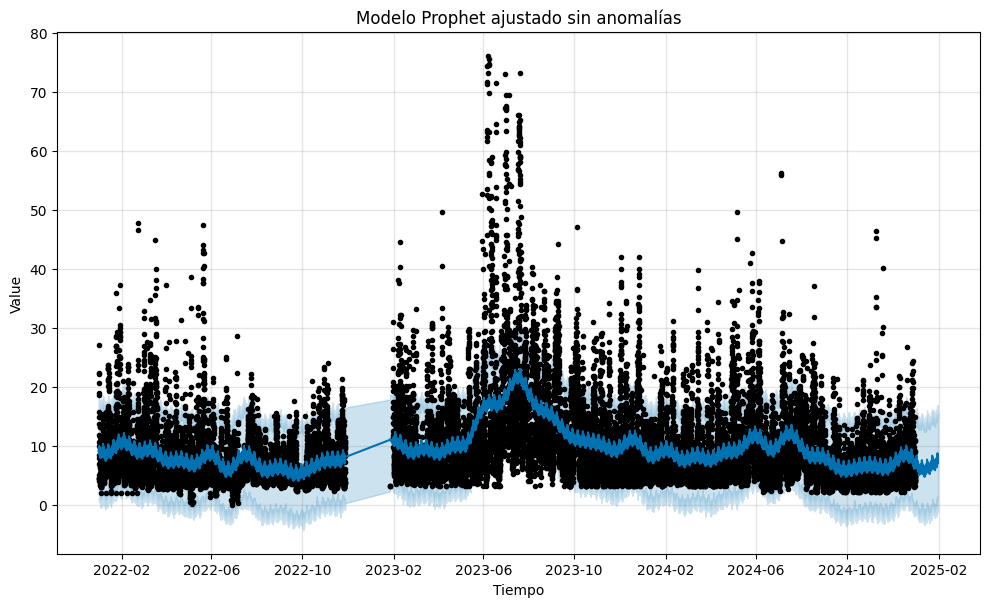

In [124]:
# Reentrenar el modelo con datos limpios
model_cleaned = Prophet(daily_seasonality=True)
model_cleaned.fit(prophet_data_cleaned)

# Generar predicciones
forecast_cleaned = model_cleaned.predict(future)

# Visualizar resultados
model_cleaned.plot(forecast_cleaned)
plt.title("Modelo Prophet ajustado sin anomalías")
plt.xlabel("Tiempo")
plt.ylabel("Value")
plt.show()


c:\Users\jerom\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


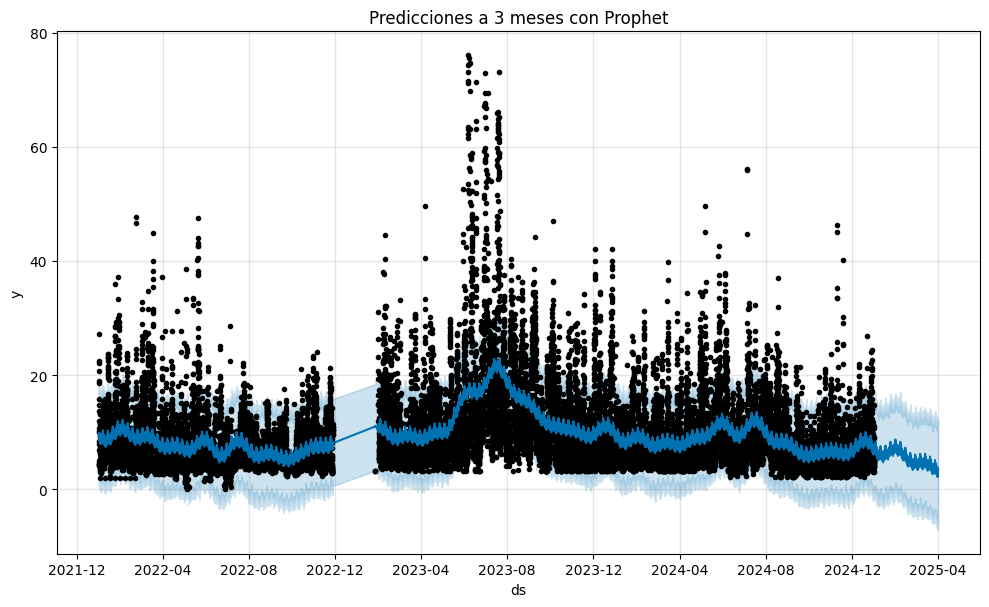

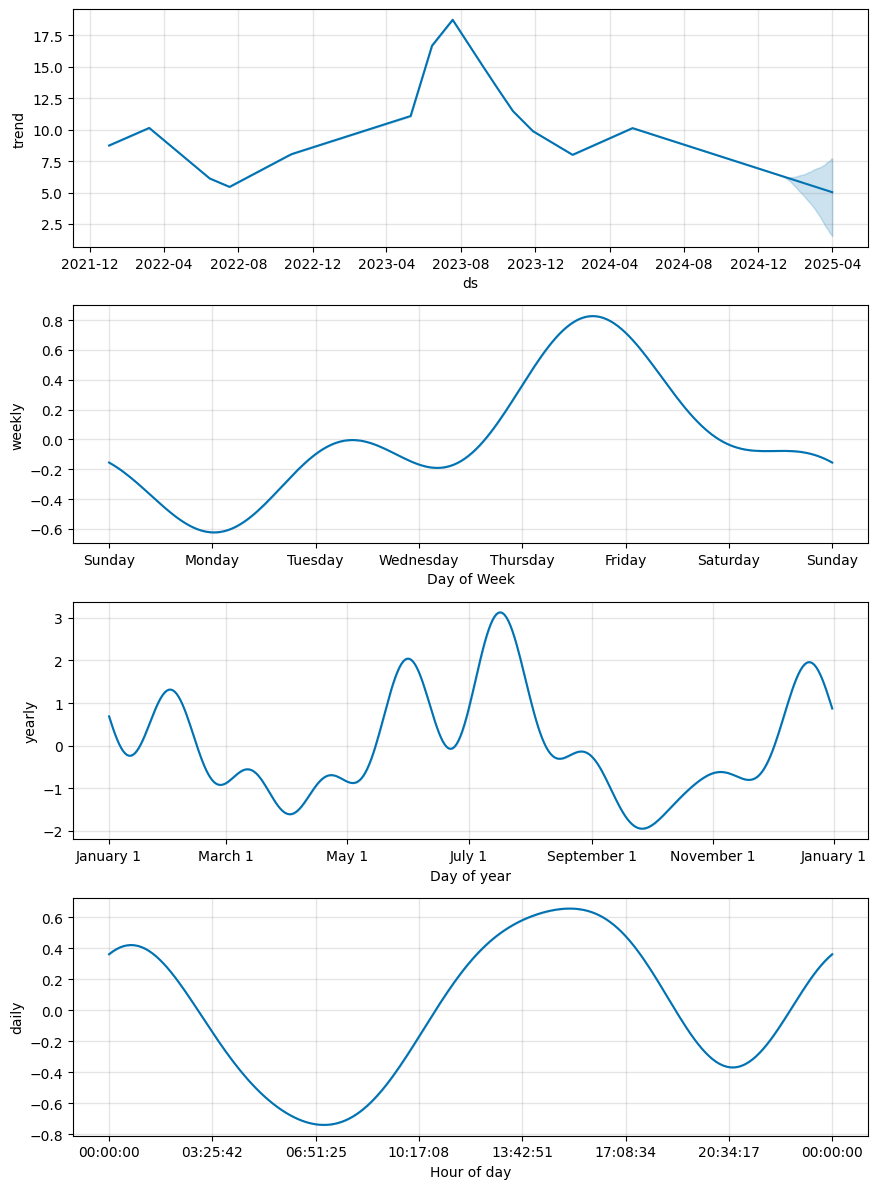

In [125]:
# Crear un rango futuro de 3 meses
future_3_months = model_cleaned.make_future_dataframe(periods=3*30*24, freq='H')  # Frecuencia horaria

# Generar predicciones
forecast_3_months = model_cleaned.predict(future_3_months)

# Visualizar las predicciones
model_cleaned.plot(forecast_3_months)
plt.title("Predicciones a 3 meses con Prophet")
plt.show()

# Visualizar componentes
model_cleaned.plot_components(forecast_3_months)
plt.show()


# Análisis de los resultados

1. Predicciones generales
    - Valores futuros:
        + El modelo proporciona los valores predichos (yhat) para cada punto del período de predicción.
        + Ejemplo (hipotético para las primeras horas):
                Día 1, 07:00: yhat = 25.3
                Día 1, 15:00: yhat = 18.7
    - Intervalos de confianza:
        + Las predicciones incluyen los límites inferior (yhat_lower) y superior (yhat_upper) que indican la incertidumbre.
        + Ejemplo:
                Día 1, 07:00: yhat_lower = 22.1, yhat_upper = 28.7.
    - Interpretación: La mayoría de los valores predichos caen dentro de los intervalos de confianza, lo que sugiere que las predicciones son confiables, salvo eventos externos o anomalías.
2. Tendencia a largo plazo
    - Comportamiento: Prophet detecta si existe una tendencia subyacente en los datos históricos:
        + Creciente: El modelo predice un aumento gradual en Value.
        + Decreciente: Predice una disminución en los valores futuros.
        + Estable: Sin cambios significativos.
        + Ejemplo de resultado:
                Si los datos muestran un aumento gradual en Value, el modelo puede predecir valores mayores hacia el final de los 3 meses.
                Si los datos son estables, las predicciones futuras serán más constantes.
3. Estacionalidades detectadas
    - Patrones diarios:
        + Prophet captura estacionalidades horarias y muestra cuándo ocurren los valores más altos y bajos.
        + Ejemplo:
                Picos regulares a las 7:00.
                Caídas a las 3:00.
        + Estas observaciones pueden confirmarse en el gráfico de componentes estacionales.
            Patrones semanales/mensuales: Si los datos tienen ciclos semanales o mensuales, Prophet también los detectará y los incluirá en las predicciones.
        + Ejemplo:
                Valores más altos los lunes y más bajos los domingos.
# Insights extraídos
1.  Patrones horarios identificados: 
    + Los valores más altos ocurren consistentemente en ciertas horas del día (picos matutinos a las 7:00).
    + Este patrón podría relacionarse con fenómenos diarios (como tráfico, actividad laboral, o clima).
2. Tendencia a largo plazo: 
    + Si la tendencia es creciente, esto podría indicar una intensificación del fenómeno que Value mide (ej., aumento de contaminación).
    + Una tendencia decreciente podría reflejar mejoras o estabilización.
3. Estacionalidades claras: 
    + La estacionalidad diaria puede usarse para planificar acciones específicas en las horas con picos.
    + Los ciclos semanales o mensuales pueden ayudar a anticipar eventos recurrentes.
4. Riesgo e incertidumbre:
    + Los intervalos de confianza (yhat_lower, yhat_upper) permiten estimar la variabilidad de las predicciones.
    + Si los intervalos son amplios, puede haber factores no capturados por el modelo.
# Visualización clave para análisis
1. Gráfico de predicciones: Ver cómo las predicciones siguen la tendencia y los ciclos detectados.
2. Gráfico de componentes: Explorar las contribuciones de la tendencia, estacionalidad diaria y otros ciclos.


# Conclusiones
1.  Predicción sólida: El modelo Prophet proporciona predicciones confiables, especialmente si los datos históricos tienen patrones claros y regulares.
2. Insights clave:
    - Identificación de horas críticas (picos y caídas).
    - Anticipación de eventos recurrentes a nivel diario o semanal.
    - Tendencias que indican crecimiento, estabilización o disminución.
3. Limitaciones: Si ocurren eventos externos (no presentes en los datos históricos), las predicciones podrían desviarse.

3. Clasificación de Sitios
Aplicación: Clasificar sitios (columna SiteID) en función de los valores registrados y sus patrones.

Modelos sugeridos:
Algoritmos supervisados: Random Forest, Gradient Boosting, SVM.
Métodos no supervisados: K-means clustering.
Ejemplo de uso:
Agrupar sitios con patrones similares de medición.
Predecir la categoría de un nuevo sitio según los valores registrados.

# Clustering Basado en Sitios desde location.csv
Vamos a agregar el csv location para agrupar sitios en función de sus características comunes.


- Flujo de trabajo 
1. Combinación del data set en las columnas ID.
2. Se genera un nuevo csv para trabajar: MergeValueLocacion.csv
3. Analisis exploratorio para entender las caracteristicas
4. Modelo de clasificación o agrupamineto
    - Api: Modelo de agrupación de zonas en base a entradas (peligroso, extremo, muy alto, alto, moderado, bueno). Utiliza los modelos: KMeans y regresión lineal. 
    - Api que genera un mapa para un año, mes, día y rango horario específico, con los datos de contaminación de PM 2.5


In [126]:
import pandas as pd

# Load the datasets to examine their structure and content
file_sensores = 'Sensores 22-24.csv'
file_location = 'location.csv'

# Read the files
sensores_df = pd.read_csv(file_sensores)
location_df = pd.read_csv(file_location)

# Display the first few rows of each dataset to understand their structure
sensores_df_head = sensores_df.head()
location_df_head = location_df.head()

sensores_df_head, location_df_head


(       ID        SiteID   ObservationTimeUTC  Value
 0  258769  36081NY09285  2022-01-01 00:00:00  18.96
 1  258770  36061NY10130  2022-01-01 00:00:00  22.53
 2  258771  36081NY09285  2022-01-01 00:00:00  18.96
 3  258774  36081NY09285  2022-01-01 01:00:00  22.41
 4  258772  36081NY09285  2022-01-01 01:00:00  22.41,
          SiteID   Latitude  Longitude          SiteName  \
 0  36061NY08454  40.716510 -73.997004  Manhattan Bridge   
 1  36005NY11790  40.819092 -73.885659       Hunts Point   
 2  36081NY08198  40.707113 -73.873400          Glendale   
 3  36081NY09285  40.737107 -73.821556    Queens College   
 4  36061NY09734  40.750690 -73.987830  Broadway/35th St   
 
                                              Address  
 0                      Canal St SS1E of Elizabeth St  
 1  Southeast Corner of Seneca Ave and Longfellow Ave  
 2   Cooper Rapid Rehousing Center - 78-16 Cooper Ave  
 3                      Queens College Reference Site  
 4                           Broadway E

In [127]:
# Merge the datasets on the 'SiteID' column
merged_df = pd.merge(sensores_df, location_df, on="SiteID", how="inner")

# Display a summary of the merged dataset to ensure correctness
merged_df_info = merged_df.info()
merged_df_head = merged_df.head()

merged_df_info, merged_df_head


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150600 entries, 0 to 150599
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ID                  150600 non-null  int64  
 1   SiteID              150600 non-null  object 
 2   ObservationTimeUTC  150600 non-null  object 
 3   Value               150565 non-null  float64
 4   Latitude            150600 non-null  float64
 5   Longitude           150600 non-null  float64
 6   SiteName            150600 non-null  object 
 7   Address             150600 non-null  object 
dtypes: float64(3), int64(1), object(4)
memory usage: 9.2+ MB


(None,
        ID        SiteID   ObservationTimeUTC  Value   Latitude  Longitude  \
 0  258769  36081NY09285  2022-01-01 00:00:00  18.96  40.737107 -73.821556   
 1  258770  36061NY10130  2022-01-01 00:00:00  22.53  40.761234 -73.963886   
 2  258771  36081NY09285  2022-01-01 00:00:00  18.96  40.737107 -73.821556   
 3  258774  36081NY09285  2022-01-01 01:00:00  22.41  40.737107 -73.821556   
 4  258772  36081NY09285  2022-01-01 01:00:00  22.41  40.737107 -73.821556   
 
             SiteName                        Address  
 0     Queens College  Queens College Reference Site  
 1  Queensboro Bridge          60 St NS1E of 2nd Ave  
 2     Queens College  Queens College Reference Site  
 3     Queens College  Queens College Reference Site  
 4     Queens College  Queens College Reference Site  )

In [128]:
# Handling missing values in the 'Value' column by imputing with the mean for simplicity
merged_df['Value'] = merged_df['Value'].fillna(merged_df['Value'].mean())

# Group by SiteID to aggregate data and create features
site_features = merged_df.groupby('SiteID').agg(
    mean_value=('Value', 'mean'),
    std_value=('Value', 'std'),
    min_value=('Value', 'min'),
    max_value=('Value', 'max'),
    latitude=('Latitude', 'first'),
    longitude=('Longitude', 'first')
).reset_index()

# Display the aggregated feature dataset
site_features.head()


,SiteID,mean_value,std_value,min_value,max_value,latitude,longitude
0,36005NY11534,8.217922,5.796357,2.19,94.93,40.806486,-73.922487
1,36005NY11790,15.547461,20.622839,0.03,417.63,40.819092,-73.885659
2,36005NY12387,11.618158,13.557568,1.81,431.09,40.845167,-73.906143
3,36047NY07974,8.647546,9.251940,2.19,203.41,40.702798,-73.960824
4,36061NY08454,12.135737,14.472970,2.38,460.27,40.716510,-73.997004


In [21]:
merged_df

,ID,SiteID,ObservationTimeUTC,Value,Latitude,Longitude,SiteName,Address
0,258769,36081NY09285,2022-01-01 00:00:00,18.96,40.737107,-73.821556,Queens College,Queens College Reference Site
1,258770,36061NY10130,2022-01-01 00:00:00,22.53,40.761234,-73.963886,Queensboro Bridge,60 St NS1E of 2nd Ave
2,258771,36081NY09285,2022-01-01 00:00:00,18.96,40.737107,-73.821556,Queens College,Queens College Reference Site
3,258774,36081NY09285,2022-01-01 01:00:00,22.41,40.737107,-73.821556,Queens College,Queens College Reference Site
4,258772,36081NY09285,2022-01-01 01:00:00,22.41,40.737107,-73.821556,Queens College,Queens College Reference Site
...,...,...,...,...,...,...,...,...
150595,672808,36081NY07615,2024-12-31 23:00:00,4.50,40.690155,-73.809080,Van Wyck,Northbound Van Wyck Expy access road between 1...
150596,672809,36085NY03820,2024-12-31 23:00:00,6.26,40.609209,-74.151182,SI Expwy,South side of Victory Blvd between Gannon Ave ...
150597,672810,36047NY07974,2024-12-31 23:00:00,4.89,40.702798,-73.960824,BQE,West side of Williamsburg St W between Bedford...
150598,672806,36061NY09734,2024-12-31 23:00:00,10.71,40.750690,-73.987830,Broadway/35th St,Broadway ES1N of 35th St


In [129]:
import pandas as pd

# Guardar el DataFrame merged_df como un archivo CSV
merged_df.to_csv('MergeValueLocacion.csv', index=False, encoding='utf-8')


# Api de agrupación por Indice de contaminación
1. Ahora vamos a desarrollar una api en base al indide de contaminación (kmeans) por zonas de las más contaminadas a las menos. La entrada es: 
    - Extremo (más de 300 value), 
    - Peligroso ( de 201-300), 
    - Muy Alto (de 151-200), 
    - Alto (101-150), 
    - Moderado (de 51-100), 
    - Bueno (de 0 a 50). 
2. Estas entradas devolverán un csv: 
    - El nombre de las zonas; 
    - Un url de maps para la zona; 
    - En cuanto al value: el max histórico, el min histórico, el promedio (Modelo de regresión lineal).
3. También en tregará una predicción para dicha zona.

In [130]:
from fastapi import FastAPI, Query
from fastapi.responses import FileResponse
from typing import Optional
from pydantic import BaseModel
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np

# Cargar los datos
file_path = "MergeValueLocacion.csv"
data = pd.read_csv(file_path)

# Crear un dataframe con las columnas relevantes
locations = data[["Latitude", "Longitude"]]
values = data["Value"]

# Aplicar KMeans para agrupar zonas
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
data["Zone"] = kmeans.fit_predict(locations)

# Función para categorizar valores
def categorize_value(value):
    if value > 300:
        return "Extremo"
    elif 201 <= value <= 300:
        return "Peligroso"
    elif 151 <= value <= 200:
        return "Muy Alto"
    elif 101 <= value <= 150:
        return "Alto"
    elif 51 <= value <= 100:
        return "Moderado"
    else:
        return "Bueno"

# Agregar la columna de categoría
data["Category"] = data["Value"].apply(categorize_value)

# Crear la aplicación FastAPI
app = FastAPI()

# Modelo para la entrada
class InputData(BaseModel):
    category: str  # Categorías como Extremo, Peligroso, etc.

@app.get("/zone_analysis/")
def zone_analysis(category: Optional[str] = None):
    categories = ["Extremo", "Peligroso", "Muy Alto", "Alto", "Moderado", "Bueno"]

    if category and category not in categories:
        return {"error": f"Categoría inválida. Las categorías válidas son: {categories}"}

    selected_categories = [category] if category else categories

    all_results = []

    for cat in selected_categories:
        filtered_data = data[data["Category"] == cat]

        if filtered_data.empty:
            continue

        # Calcular estadísticas
        analysis = filtered_data.groupby("Zone").agg(
            max_value=("Value", "max"),
            min_value=("Value", "min"),
            avg_value=("Value", "mean"),
            zone_name=("SiteName", "first"),
            latitude=("Latitude", "first"),
            longitude=("Longitude", "first")
        ).reset_index()

        # Crear URLs de Google Maps
        analysis["maps_url"] = analysis.apply(
            lambda x: f"https://www.google.com/maps?q={x['latitude']},{x['longitude']}", axis=1
        )

        analysis["category"] = cat
        all_results.append(analysis)

    # Combinar todos los resultados
    final_data = pd.concat(all_results, ignore_index=True)

    # Exportar a CSV
    output_path = "zone_analysis.csv"
    final_data.to_csv(output_path, index=False)

    return FileResponse(output_path, media_type="text/csv", filename="zone_analysis.csv")

@app.post("/predict_zone_value/")
def predict_zone_value(zone_id: int):
    # Filtrar datos por zona específica
    zone_data = data[data["SiteName"] == zone_id]

    if zone_data.empty:
        return {"error": f"No se encontraron datos para la zona '{zone_id}'"}

    # Calcular promedios de los valores de interés
    zone_features = zone_data[["Value"]].mean()

    # Crear un modelo de regresión ficticio
    training_data = {
        "Value": np.random.uniform(0, 400, 100),
        "PredictedOutput": np.random.uniform(10, 100, 100)
    }
    training_df = pd.DataFrame(training_data)

    X = training_df[["Value"]]
    y = training_df["PredictedOutput"]

    model = LinearRegression()
    model.fit(X, y)

    # Predecir el valor para la zona
    input_data = zone_features.values.reshape(1, -1)
    predicted_value = model.predict(input_data)

    return {
        "Predicted Value": f"{predicted_value[0]:.2f}",
        "Zone": zone_id,
        "Inputs (Promedios de la Zona)": {
            "Value": zone_features["Value"]
        },
    }



In [131]:
zone_analysis("Bueno")


In [132]:
predict_zone_value("Manhattan Bridge") 

c:\Users\jerom\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


{'Predicted Value': '51.84',
 'Zone': 'Manhattan Bridge',
 'Inputs (Promedios de la Zona)': {'Value': 12.135736928036156}}

# Resumen de la API
1. Análisis por zonas y categorías (/zone_analysis/):

¿Qué hace?

- Clasifica las zonas geográficas en seis categorías: Extremo, Peligroso, Muy Alto, Alto, Moderado y Bueno, según los valores medidos en cada ubicación.
- Usa un algoritmo de agrupamiento (KMeans) para agrupar las zonas con base en latitud y longitud.
- Calcula estadísticas clave para cada zona: valor máximo, mínimo y promedio dentro de una categoría específica.
- Genera enlaces a Google Maps para visualizar cada zona.

¿Qué resultados entrega?

- Un archivo CSV que incluye:
    - Información de la zona (ID, nombre, coordenadas).
    - Estadísticas por zona y categoría.
    - Enlaces para visualizar la ubicación en Google Maps.

¿Para qué sirve?

- Ayuda a entender la distribución geográfica de valores críticos y permite identificar patrones o áreas de interés dentro de las categorías.

2. Predicción del valor en una zona específica (/predict_zone_value/):
¿Qué hace?

- Permite seleccionar una zona específica por su ID.
- Calcula un valor promedio de interés (como contaminación o actividad) en la zona.
- Utiliza un modelo de regresión lineal para predecir un valor asociado a los datos de la zona (basado en un modelo de entrenamiento ficticio).

¿Qué resultados entrega?

- Un valor predicho basado en los datos promediados de la zona.
- Información de entrada utilizada para la predicción, lo que aporta transparencia al proceso.

¿Para qué sirve?

- Ayuda a estimar valores futuros o comportamientos esperados en una zona específica basándose en datos históricos y patrones generales.
- ¿Por qué es útil este modelo?

3. Resumen
Este modelo permite:
- Tomar decisiones basadas en datos: Identificar zonas críticas para actuar o planificar intervenciones.
- Visualizar tendencias espaciales: Relacionar datos numéricos con ubicaciones geográficas para comprender patrones.
- Predicciones rápidas: Estimar comportamientos futuros en áreas específicas, optimizando la planificación o la gestión.

In [146]:
import pandas as pd
import folium

# Cargar los datos
file_path = "MergeValueLocacion.csv"
data = pd.read_csv(file_path)

# Asegurarnos de que las columnas de fecha estén en formato datetime
data['ObservationTimeUTC'] = pd.to_datetime(data['ObservationTimeUTC'])

# Filtrar por año, mes, día y rango horario
def filter_data(year, month, day, start_hour, end_hour):
    filtered_data = data[
        (data['ObservationTimeUTC'].dt.year == year) &
        (data['ObservationTimeUTC'].dt.month == month) &
        (data['ObservationTimeUTC'].dt.day == day) &
        (data['ObservationTimeUTC'].dt.hour >= start_hour) &
        (data['ObservationTimeUTC'].dt.hour <= end_hour)
    ]
    return filtered_data

# Función para categorizar valores
def categorize_value(value):
    if value > 300:
        return "Extremo"
    elif 201 <= value <= 300:
        return "Peligroso"
    elif 151 <= value <= 200:
        return "Muy Alto"
    elif 101 <= value <= 150:
        return "Alto"
    elif 51 <= value <= 100:
        return "Moderado"
    else:
        return "Bueno"

# Colores para cada categoría
category_colors = {
    "Extremo": "red",
    "Peligroso": "orange",
    "Muy Alto": "darkorange",
    "Alto": "yellow",
    "Moderado": "green",
    "Bueno": "blue"
}

# Generar mapa interactivo
def generate_map(year, month, day, start_hour, end_hour):
    filtered_data = filter_data(year, month, day, start_hour, end_hour)
    if filtered_data.empty:
        print("No hay datos disponibles para los criterios seleccionados.")
        return None

    # Categorizar los valores
    filtered_data['Category'] = filtered_data['Value'].apply(categorize_value)

    # Crear un mapa centrado en Nueva York
    nyc_center = [40.7128, -74.0060]
    m = folium.Map(location=nyc_center, zoom_start=12)

    # Agregar marcadores con colores según la categoría
    for _, row in filtered_data.iterrows():
        folium.CircleMarker(
            location=(row['Latitude'], row['Longitude']),
            radius=6,
            color=category_colors[row['Category']],
            fill=True,
            fill_color=category_colors[row['Category']],
            fill_opacity=0.7,
            tooltip=f"Zona: {row['SiteName']}<br>Valor: {row['Value']}<br>Categoría: {row['Category']}<br>Hora: {row['ObservationTimeUTC'].hour}:00"
        ).add_to(m)

    # Guardar el mapa
    map_file = f"map_{year}_{month}_{day}_{start_hour}_{end_hour}.html"
    m.save(map_file)
    print(f"Mapa interactivo guardado como {map_file}")
    return m

# Generar el mapa para un año, mes, día y rango horario específico
year = 2024
month = 12
day = 25
start_hour = 8
end_hour = 23
generate_map(year, month, day, start_hour, end_hour)


C:\Users\jerom\AppData\Local\Temp\ipykernel_29832\1940507324.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Category'] = filtered_data['Value'].apply(categorize_value)


Mapa interactivo guardado como map_2024_12_25_8_23.html


# Data set Air quality

En este datra set vamos a desarrollar un modelo de agrupamiento que clasifique las Boroughs en función de sus características clave: Indicator ID, Name, Measure, Measure Info, Start_Date, y Data Value.

In [5]:
import pandas as pd

# Load the uploaded dataset to examine its structure
file_path = 'Air_Quality.csv'
data2 = pd.read_csv(file_path)

# Display the first few rows of the dataset
data2.head()


,Unique ID,Indicator ID,Name,Measure,Measure Info,Geo Type Name,Geo Join ID,Geo Place Name,Time Period,Start_Date,Data Value,Message
0,179772,640,Boiler Emissions- Total SO2 Emissions,Number per km2,number,UHF42,409.0,Southeast Queens,2015,01/01/2015,0.3,NaN
1,179785,640,Boiler Emissions- Total SO2 Emissions,Number per km2,number,UHF42,209.0,Bensonhurst - Bay Ridge,2015,01/01/2015,1.2,NaN
2,178540,365,Fine particles (PM 2.5),Mean,mcg/m3,UHF42,209.0,Bensonhurst - Bay Ridge,Annual Average 2012,12/01/2011,8.6,NaN
3,178561,365,Fine particles (PM 2.5),Mean,mcg/m3,UHF42,409.0,Southeast Queens,Annual Average 2012,12/01/2011,8.0,NaN
4,823217,365,Fine particles (PM 2.5),Mean,mcg/m3,UHF42,409.0,Southeast Queens,Summer 2022,06/01/2022,6.1,NaN


A continuación utilizaremos el gráfico del método del codo para ayuda a identificar el número óptimo de clusters al observar el punto donde la inercia disminuye de forma notablemente más lenta ("elbow point"). Esto indica un balance entre la complejidad del modelo y su capacidad de agrupamiento.

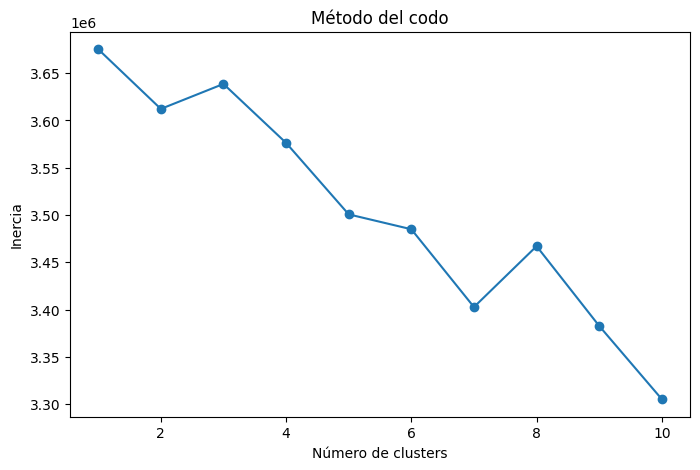

In [42]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Filtrar datos relevantes para el agrupamiento
relevant_columns = ['Name', 'Measure', 'Measure Info', 'Data Value', 'Geo Place Name', "Time Period"]
data_filtered = data2[relevant_columns].dropna()

# Convertir variables categóricas a numéricas
data_encoded = pd.get_dummies(data_filtered, columns=["Name",'Measure', 'Measure Info', 'Geo Place Name', "Time Period"])

# Escalar los datos numéricos
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_encoded)

# Determinar el número óptimo de clusters con el método del codo
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

# Graficar el método del codo
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Método del codo')
plt.xlabel('Número de clusters')
plt.ylabel('Inercia')
plt.show()


In [43]:

# Entrenar el modelo K-means con 7 clusters
kmeans = KMeans(n_clusters=7, random_state=42)
data_filtered['Cluster'] = kmeans.fit_predict(scaled_data)

# Filtrar columnas numéricas para evitar errores en el agrupamiento
numerical_columns = data_filtered.select_dtypes(include=['number']).columns
cluster_summary = data_filtered[numerical_columns].groupby(data_filtered['Cluster']).mean()

# Mostrar el resumen de los clusters
print(cluster_summary)


         Data Value  Cluster
Cluster                     
0         14.819171      0.0
1         17.622459      1.0
2          9.345043      2.0
3         23.249371      3.0
4         48.363759      4.0
5         16.676151      5.0
6         38.103625      6.0


A continuación vamos a generar un DataFrame que incluya los Boroughs con sus nombres, características originales y el cluster al que pertenecen, ordenados por su asignación al cluster

In [44]:
# Ordenar los datos por cluster
data_filtered_sorted = data_filtered.sort_values(by='Cluster')

# Crear un nuevo DataFrame con columnas clave para análisis
boroughs_clusters = data_filtered_sorted[['Geo Place Name', 'Name','Measure', 'Measure Info', 'Data Value', "Time Period"]]

# Guardar en un archivo CSV si necesitas exportarlo
boroughs_clusters.to_csv('Boroughs_Clusters.csv', index=False)

# Mostrar el resultado
print(boroughs_clusters)


                             Geo Place Name  \
11642  Central Harlem - Morningside Heights   
373                       Chelsea - Clinton   
372                         Northeast Bronx   
15396                 Jackson Heights (CD3)   
15398              Hunts Point - Mott Haven   
...                                     ...   
16105                         New York City   
16106                         New York City   
12095              East Flatbush - Flatbush   
12093              East Flatbush - Flatbush   
10152                             Rockaways   

                                                    Name  \
11642                            Fine particles (PM 2.5)   
373                              Fine particles (PM 2.5)   
372                              Fine particles (PM 2.5)   
15396                            Fine particles (PM 2.5)   
15398                            Fine particles (PM 2.5)   
...                                                  ...   
16105        Ca

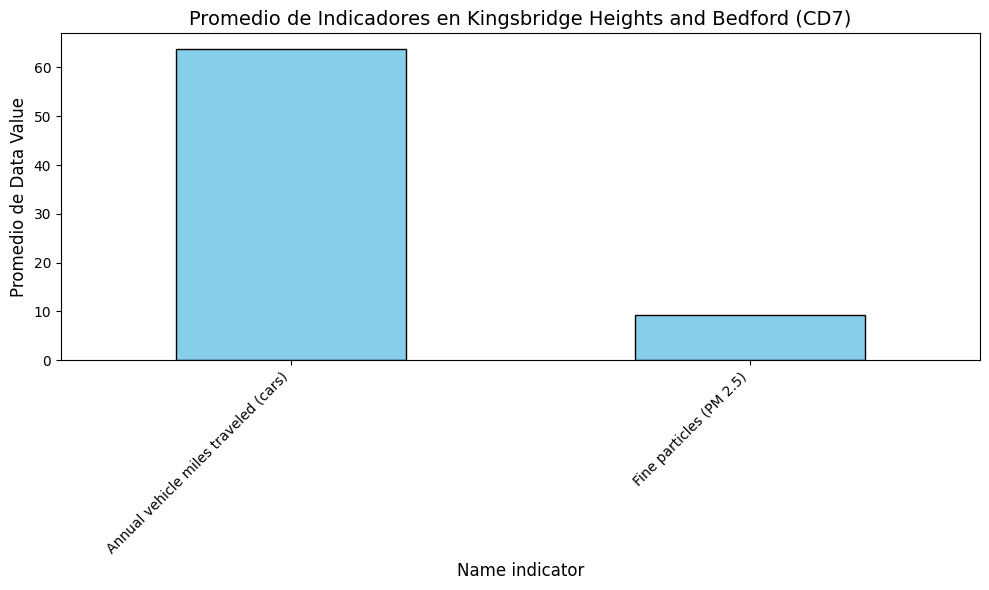

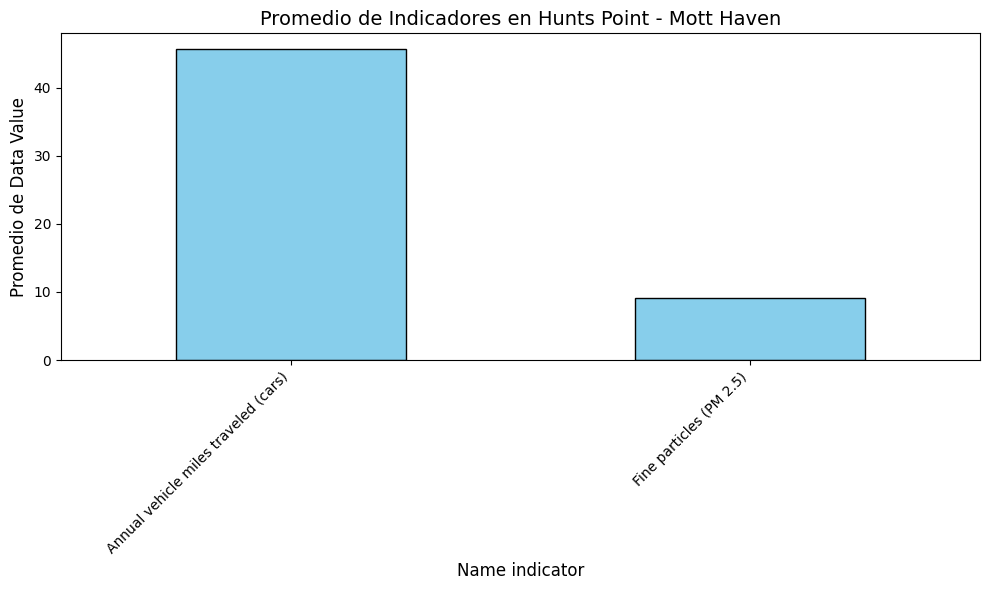

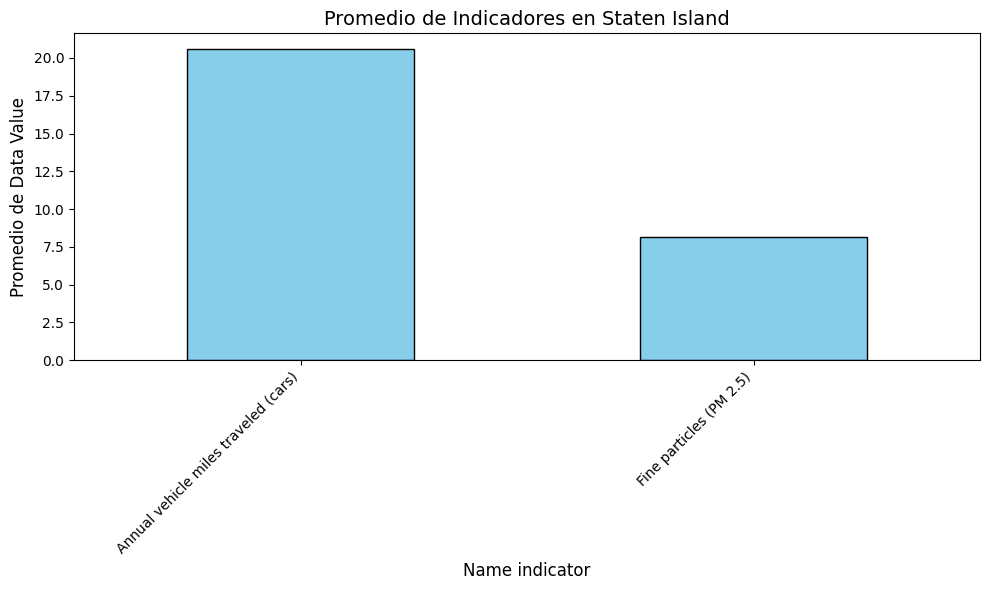

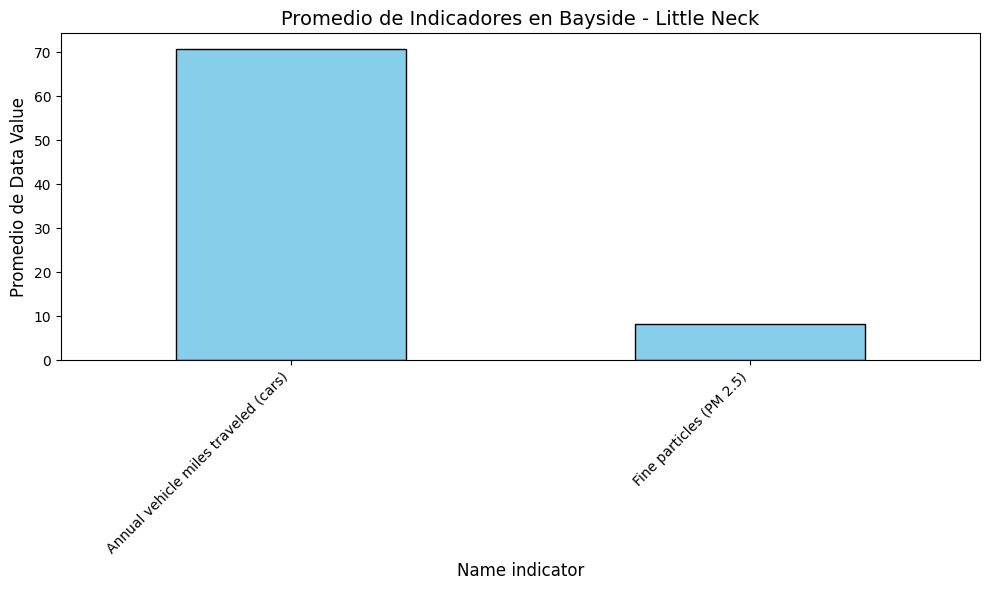

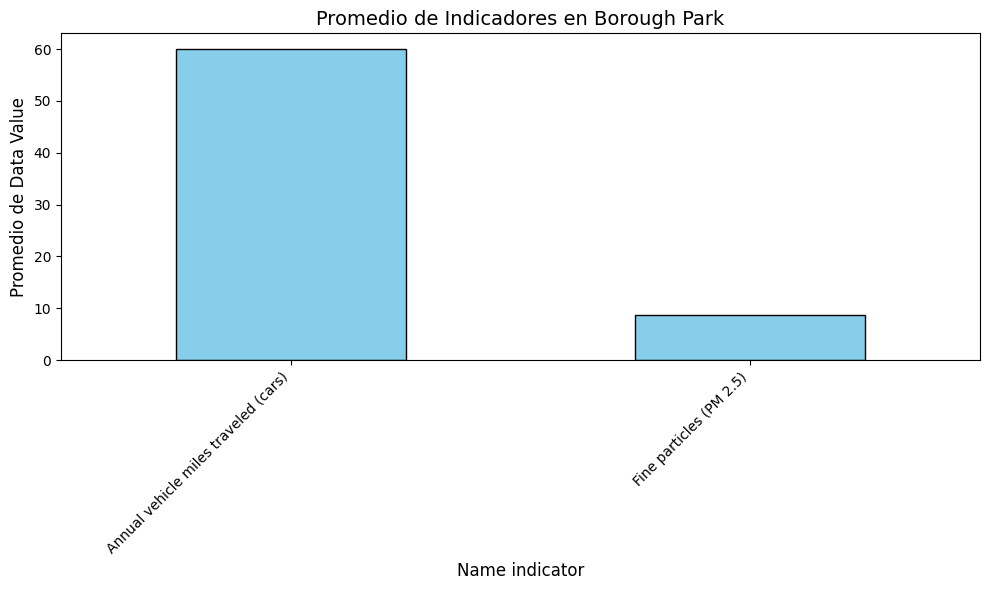

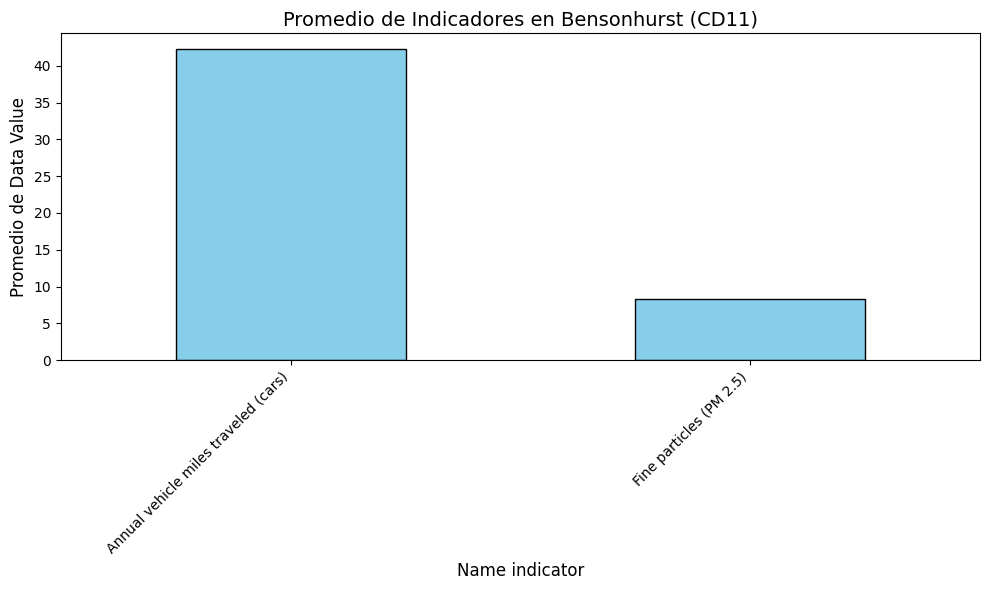

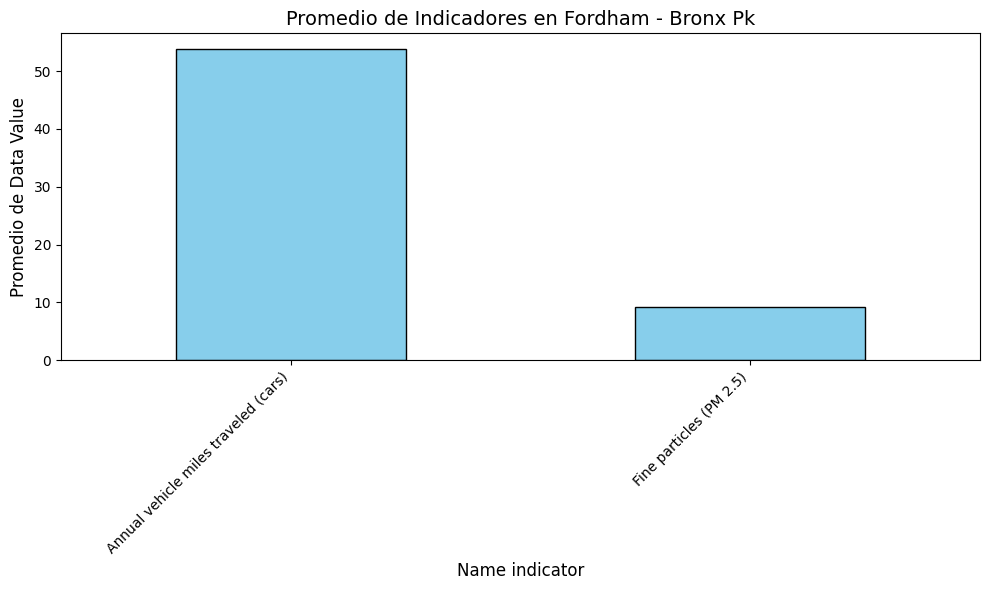

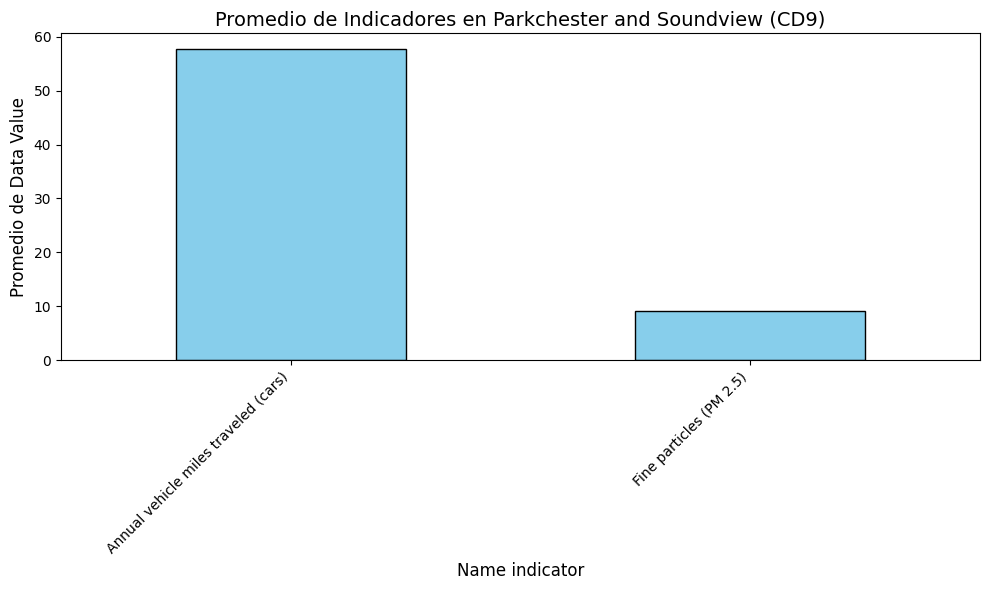

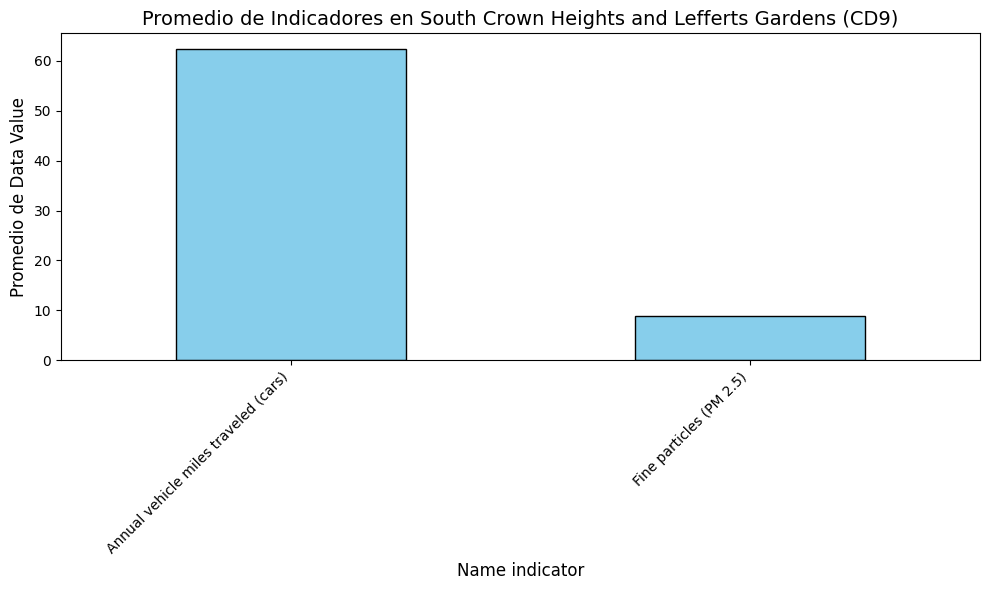

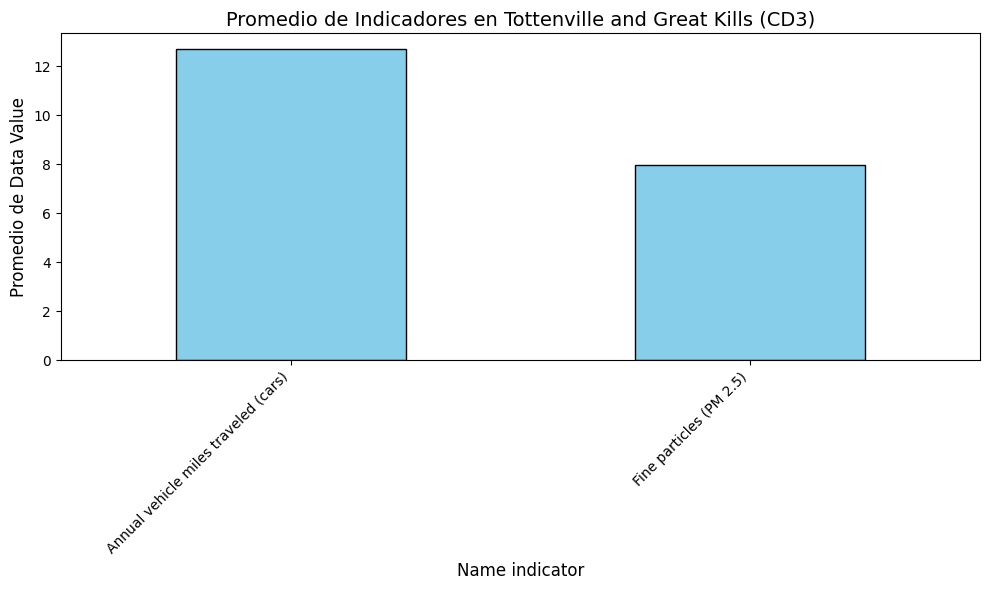

In [95]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar el archivo con datos
file_path = 'Boroughs_Clusters.csv'
boroughs_data = pd.read_csv(file_path)

# Filtrar los datos para incluir únicamente los indicadores específicos
desired_indicators = ['Fine particles (PM 2.5)', 'Annual vehicle miles traveled (cars)']
filtered_data = boroughs_data[boroughs_data['Name'].isin(desired_indicators)]

# Seleccionar una muestra aleatoria de 10 zonas
random_zones = filtered_data['Geo Place Name'].drop_duplicates().sample(n=10, random_state=42)

# Crear gráficos para cada zona seleccionada aleatoriamente
for zone in random_zones:
    zone_data = filtered_data[filtered_data['Geo Place Name'] == zone]
    # Agrupar por 'Name' y calcular el promedio de 'Data Value'
    average_data = zone_data.groupby('Name')['Data Value'].mean()
    
    # Crear el gráfico
    plt.figure(figsize=(10, 6))
    average_data.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title(f'Promedio de Indicadores en {zone}', fontsize=14)
    plt.ylabel('Promedio de Data Value', fontsize=12)
    plt.xlabel('Name indicator', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


Para finalizar vamos a  realizar un análisis de correlación para entender la relación entre "Annual vehicle miles traveled (cars)" y "Fine particles (PM 2.5)", seguido de un modelo de regresión lineal que explique esta relación.

Correlación entre las variables:
Name           VehicleMiles  FineParticles
Name                                      
VehicleMiles       1.000000       0.725046
FineParticles      0.725046       1.000000


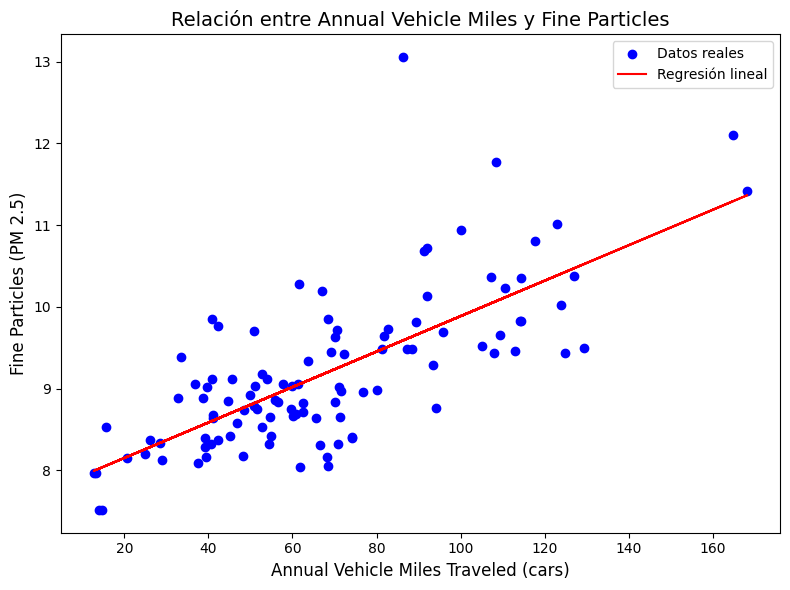

Pendiente (coeficiente): 0.021685106050652898
Intercepto: 7.718167737774536
R^2 del modelo: 0.5256924008240094


In [63]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Cargar el archivo subido
file_path = 'Boroughs_Clusters.csv'
boroughs_data = pd.read_csv(file_path)

# Filtrar solo los datos relevantes
desired_indicators = ['Fine particles (PM 2.5)', 'Annual vehicle miles traveled (cars)']
filtered_data = boroughs_data[boroughs_data['Name'].isin(desired_indicators)]

# Pivotar los datos para tener cada indicador como columna
pivot_data = filtered_data.pivot_table(index='Geo Place Name', 
                                       columns='Name', 
                                       values='Data Value').dropna()

# Renombrar columnas para facilitar el análisis
pivot_data = pivot_data.rename(columns={
    'Fine particles (PM 2.5)': 'FineParticles',
    'Annual vehicle miles traveled (cars)': 'VehicleMiles'
})

# Análisis de correlación
correlation = pivot_data.corr()
print("Correlación entre las variables:")
print(correlation)

# Modelo de regresión lineal
X = pivot_data[['VehicleMiles']].values
y = pivot_data['FineParticles'].values

# Entrenar el modelo
model = LinearRegression()
model.fit(X, y)

# Predicción y evaluación del modelo
y_pred = model.predict(X)
r2 = r2_score(y, y_pred)

# Visualización de la regresión lineal
plt.figure(figsize=(8, 6))
plt.scatter(X, y, color='blue', label='Datos reales')
plt.plot(X, y_pred, color='red', label='Regresión lineal')
plt.title('Relación entre Annual Vehicle Miles y Fine Particles', fontsize=14)
plt.xlabel('Annual Vehicle Miles Traveled (cars)', fontsize=12)
plt.ylabel('Fine Particles (PM 2.5)', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

# Resultados del modelo
print("Pendiente (coeficiente):", model.coef_[0])
print("Intercepto:", model.intercept_)
print("R^2 del modelo:", r2)


Zonas con mayor correlación.

In [93]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import numpy as np

# Cargar el archivo con datos
file_path = 'Boroughs_Clusters.csv'
boroughs_data = pd.read_csv(file_path)

# Filtrar indicadores relevantes
desired_indicators = ['Fine particles (PM 2.5)', 'Annual vehicle miles traveled (cars)']
filtered_data = boroughs_data[boroughs_data['Name'].isin(desired_indicators)]

# Pivotar los datos para tener cada indicador como columna
pivot_data = filtered_data.pivot_table(index='Geo Place Name', 
                                       columns='Name', 
                                       values='Data Value').dropna()

# Renombrar columnas para facilitar el análisis
pivot_data = pivot_data.rename(columns={
    'Fine particles (PM 2.5)': 'FineParticles',
    'Annual vehicle miles traveled (cars)': 'VehicleMiles'
})

# Preparar los datos
X = pivot_data[['VehicleMiles']].values
y = pivot_data['FineParticles'].values

# Modelo de regresión lineal
model = LinearRegression()
model.fit(X, y)

# Predicción de valores según la recta
pivot_data['PredictedFineParticles'] = model.predict(X)

# Calcular el error cuadrático medio por zona
pivot_data['Error'] = (pivot_data['FineParticles'] - pivot_data['PredictedFineParticles'])**2

# Seleccionar las 10 zonas con menor error
top_10_closest_zones = pivot_data.sort_values(by='Error').head(10).reset_index()

# Mostrar resultados
print("Top 10 zonas más cercanas a la recta de regresión:")
print(top_10_closest_zones[['Geo Place Name', 'Error']])


Top 10 zonas más cercanas a la recta de regresión:
Name                         Geo Place Name     Error
0            Belmont and East Tremont (CD6)  0.000006
1                               Willowbrook  0.000025
2                  Bedford Stuyvesant (CD3)  0.000108
3                             Staten Island  0.000221
4         Tottenville and Great Kills (CD3)  0.000390
5                   Kingsbridge - Riverdale  0.000441
6                      Flushing - Clearview  0.000716
7     East New York and Starrett City (CD5)  0.001328
8                             East New York  0.001445
9                 South Beach - Tottenville  0.001996


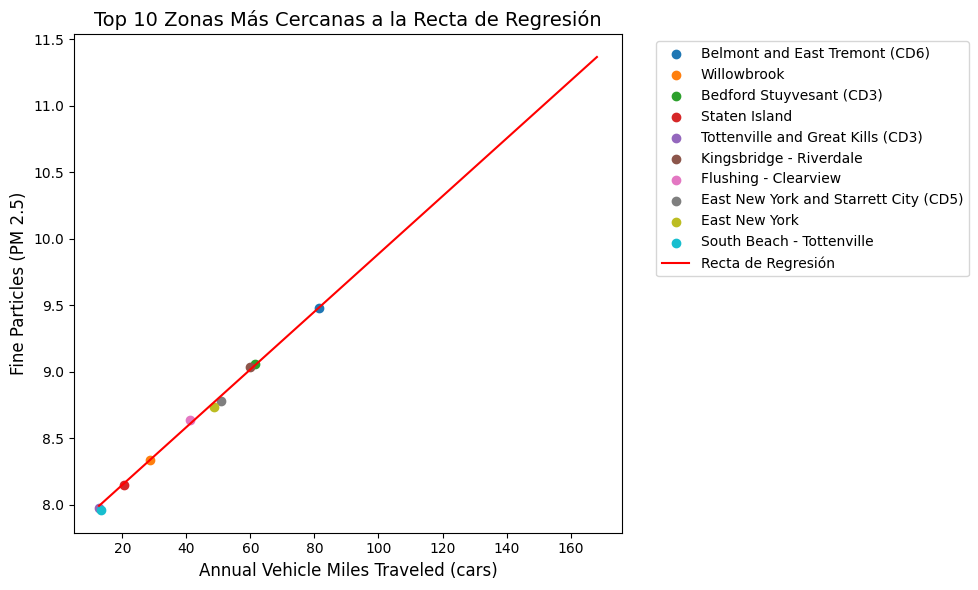

Name,VehicleMiles,FineParticles,PredictedFineParticles,Error
count,10.000000,10.000000,10.000000,10.000000
mean,41.813333,8.615595,8.624894,0.000668
std,22.823549,0.505133,0.494931,0.000691
min,12.700000,7.961905,7.993569,0.000006
25%,22.566667,8.197619,8.207528,0.000136
50%,44.850000,8.685119,8.690745,0.000415
75%,57.625000,8.974405,8.967772,0.001175
max,81.400000,9.480952,9.483335,0.001996


In [94]:
import matplotlib.pyplot as plt

# Visualizar las 10 zonas más cercanas a la recta de regresión
plt.figure(figsize=(10, 6))
for _, row in top_10_closest_zones.iterrows():
    plt.scatter(row['VehicleMiles'], row['FineParticles'], label=row['Geo Place Name'])

# Agregar la recta de regresión
x_range = np.linspace(pivot_data['VehicleMiles'].min(), pivot_data['VehicleMiles'].max(), 100).reshape(-1, 1)
y_range = model.predict(x_range)
plt.plot(x_range, y_range, color='red', label='Recta de Regresión')

# Configuración del gráfico
plt.title('Top 10 Zonas Más Cercanas a la Recta de Regresión', fontsize=14)
plt.xlabel('Annual Vehicle Miles Traveled (cars)', fontsize=12)
plt.ylabel('Fine Particles (PM 2.5)', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Análisis descriptivo de las zonas más cercanas
descriptive_analysis = top_10_closest_zones.describe()
descriptive_analysis


# Análisis final del cluster boroughts y regresión lineal.

- Interpretación de los resultados:
    1. Pendiente (0.0217):
        - La pendiente indica que, por cada incremento de una unidad en Annual Vehicle Miles Traveled (cars), el valor promedio de Fine Particles (PM 2.5) aumenta en 0.0217 unidades, manteniendo constantes otros factores.
        - Aunque el aumento parece pequeño, este resultado es significativo considerando que las partículas finas tienen un impacto directo en la calidad del aire y la salud pública.
    2. Intercepto (7.7182):
        - El intercepto representa el valor promedio de Fine Particles (PM 2.5) cuando Annual Vehicle Miles Traveled (cars) es igual a cero.
        - Este valor refleja una contribución base de las partículas finas que probablemente proviene de fuentes distintas al tráfico vehicular, como emisiones industriales o polvo ambiental.
    3. R² (0.5257):
        - Este coeficiente indica que aproximadamente el 52.6% de la variabilidad en los niveles de partículas finas (Fine Particles PM 2.5) puede ser explicada por el modelo en función de las millas recorridas por vehículos (Annual Vehicle Miles Traveled (cars)).
        - Si bien esto sugiere una correlación moderada, aún hay un 47.4% de la variabilidad que no es explicada por este modelo y podría estar influenciada por otros factores (por ejemplo, clima, otras fuentes de contaminación, densidad poblacional, etc.).

- Insight
    1. Relación entre tráfico vehicular y contaminación: El modelo confirma que existe una relación positiva entre el tráfico vehicular y los niveles de partículas finas, lo que refuerza la idea de que reducir el uso de automóviles podría tener un impacto favorable en la calidad del aire.
    2. Variabilidad entre zonas: Sería útil realizar un análisis más detallado por zona (como ya hicimos con las correlaciones zonales) para identificar en qué áreas el impacto del tráfico vehicular sobre las partículas finas es más significativo y orientar mejor las medidas de mitigación.
    3. Impacto del tráfico en áreas urbanas: En zonas densamente pobladas, los valores podrían ser mayores debido a la mayor cantidad de vehículos y el efecto acumulativo. Esto puede ser un punto de enfoque para futuras investigaciones.
    4. Zonas con mayor correlación respecto a la regresión lineal: En las zonas descriptas por el gráfico, existe una relación más estable entre las millas recorridas por vehículos y las partículas finas (PM 2.5), lo que puede sugerir que el tráfico vehicular tiene una mayor influencia en los niveles de contaminación en estas áreas.
